<a href="https://colab.research.google.com/github/gothxx/ML2021_Spring/blob/master/Hung_Yi_Lee_ML2021_Spring_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

#!unzip -q food-11.zip



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
#"ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

#This is for the progress bar.
from tqdm.auto import tqdm

import time
import matplotlib.pyplot as plt



In [ ]:
#It is important to do data augmentation in training.
#However, not every augmentation is useful.
#Please thin about what kind of augmentation is helpful for food recognition.

train_tfm = transforms.Compose([
    #Resize the image into a fixed shape (height = width = 128) 
    transforms.Resize((128, 128)),
    #You may add some transforms here.
    # toTensor() should be the last one of the transforms.
    transforms.ToTensor() ,                        
])
# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor

test_tfm = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.ToTensor(),
])


In [ ]:
# Batch size for training, validation, and testing
# A greater batch size usually gives a more table gradient.
# But the GPU memory is limited, so please adjust it carefully.

batch_size = 16

# Construct datesets.
# The argument "loader" tells how torchvision reads the data.

train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabelded_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)



In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


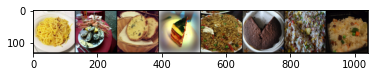

In [ ]:
# get some random training images

dataiter = iter(train_loader)
images, labels = dataiter.next()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def matplotlib_imshow(img, one_channel = False):
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

import torchvision

#create grid of images
img_grid = torchvision.utils.make_grid(images[0:8])

#show images
matplotlib_imshow(img_grid, one_channel=False)









In [ ]:

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    #The arguments for commonly used modules;
    #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    #torch.nn.MaxPool2d(kernel_size, stride, padding)

    #input image size: [3, 128, 128]
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(3, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),

        nn.Conv2d(64, 128, 3, 1, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),

        nn.Conv2d(128, 256, 3, 1, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(4, 4, 0),
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(256 * 8 * 8, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 11)
    )

  def forward(self, x):
    # input (x): [batch_size, 3, 128, 128]
    # output: [batch_size, 11]

    #Extract features by convolutional layers.
    x = self.cnn_layers(x)

    #The extracted feature map must be flatten before going to fully-connected layers.
    x = x.flatten(1)

    #The features are transformed by fully-connected layers to obtain the final logits
    x = self.fc_layers(x)

    return x



In [ ]:
def get_pseudo_label(dataset, model, threshold=0.65):
  # This functions generates pseudo-labels of a dataset using given model.
  # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
  # You are NOT allowed to use ana models trained on external data for pseudo-labeling.

  dev = "cuda" if torch.cuda.is_available() else "cpu"

  # construct a data loader.
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  # Make sure the model is in eval mode.
  model.eval()

  # define softmax function.
  softmax = nn.Softmax(dim=-1)

  # Iterate over the dataset by batches.
  for batch in tqdm(data_loader):
    img, _ = batch

    # Forwad the data
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(img.to(device))
      
      # Obtain the probability distributions by applying softmax on logits.
      probs = softmax(logits)


      # ----------------- TODO ---------------------
      #Filter the data and construct a new dataset.

  ## Turn off the eval mode.
  model.train()
  return dataset 

        

In [ ]:
# "cuda" only when GPUs are available 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 20

# Whether to do semi-supervised learning.
model_path = "./model_chpt_hw3"
do_semi = False
best_acc = 0.0
tarin_loss_recore = []
valid_loss_record = []
train_acc_recore = []
valid_acc_record = []

for epoch in range(n_epochs):
  # ----------- TODO -------------
  # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
  # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.

  if do_semi:
    # Obtain pseudo-labels for unlabeled data using trained model.
    pseudo_set = get_pseudo_labels(unlabeled_set, model)

    # Construct a new dataset and a data loader for training.
    # This is used in semi-supervised learning only.
    concat_dataset = ConcatDataset([tarin_set, pseudo_set])
    train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_Memory=True)

  #----------------------- Training --------------------------
  # Make sure the model is in train mode before training.

  model.train()

  # These are used to record information in training.
  train_loss = []
  train_accs = []

  # Iterate the training set by batches.
  for batch in tqdm(train_loader):

    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # Forward the data. (Make sure data and model are on the same device.)
    logits = model(imgs.to(device))

    # Calculate the cross-entropy loss.
    # We don't need to apply softmax before computing cross-entropy as it is done automatically.
    loss = criterion(logits, labels.to(device))

    # Clip the gradient norms for stable training.
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_accs.append(acc)

  # The average loss and accuracy of the training set is the average of the recorded values.
  train_los = sum(train_loss) / len(train_loss)
  train_acc = sum(train_accs) / len(train_accs)

  # Print the information.
  print(f"""[{time.strftime("%Y-%m-%d %H:%M:%s", time.localtime())}] [ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_los:.5f}, acc = {train_acc:.5f}""")

  # ----------------- validation -------------------------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.
  valid_loss = []
  valid_accs = []

  # Iterate the validation set by batches.
  for batch in tqdm(valid_loader):

    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # We don't need gradient in validation.
    # Using torch.no_grad() to accelerates the forward process.

    with torch.no_grad():
      logits = model(imgs.to(device))

    # We cat still compute the loss (but not the gradient).
    loss = criterion(logits, labels.to(device))

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    valid_loss.append(loss.item())
    valid_accs.append(acc)

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_los = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)

  # Print the information.
  print(f"""[{time.strftime("%Y-%m-%d %H:%M:%s", time.localtime())}] [ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_los:.5f}, acc = {valid_acc:.5f}""")

    # ------------------ Record -----------------
  if valid_acc > best_acc :
    best_acc = valid_acc
    torch.save(model.state_dict(), model_path)

  train_loss_record.append(train_los)
  valid_loss_record.append(valid_los)
  train_acc_record.append(train_acc)
  valid_acc_record.append(valid_acc)


  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/193 [00:00<?, ?it/s]

[2021-12-17 09:49:1639734571] [ Train | 001/020 ] loss = 2.40054, acc = 0.08484


  0%|          | 0/42 [00:00<?, ?it/s]

[2021-12-17 09:49:1639734579] [ Valid | 001/020 ] loss = 2.40154, acc = 0.09524


NameError: ignored

In [ ]:

x = np.arrange(len(train_acc_record))
plt.plot(x, train_acc_record, color = "blue", label = "Train")
plt.plot(x, valid_acc_record, color = "red", label = "Valid")
plt.legend(loc="upper right")
plt.show()


In [ ]:
x = np.arrange(len(train_acc_record))
plt.plot(x, train_loss_record, color = "blue", label = "Train")
plt.plot(x, valid_loss_record, color = "red", label = "Valid")
plt.legend(loc="upper right")
plt.show()


In [ ]:
model.eval()

predictions = []

for batch in test_loader:
  imgs, labels = batch
  
  with torch.no_grad():
    logits = model(imgs.to(device))

  predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


with open("predict.csv", "w") as f:
  f.write("Id,Category\n")

  for i, pred in enumerate(predictions):
    f.write(f"{i},{pred}\n")
      